In [1]:
# get the codes from https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation/notebook
# Import stuff
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    
    #Comment from Rangel Dokov:
    #You should be able to get a faster version by just using more OpenCV functions instead of SciPy. 
    #I managed to get about 4x improvement by using:
    # include 4 standard deviations in the kernel (the default for ndimage.gaussian_filter)
    # OpenCV also requires an odd size for the kernel hence the "| 1" part
    #blur_size = int(4*sigma) | 1
    #cv2.GaussianBlur(image, ksize=(blur_size, blur_size), sigmaX=sigma)
    #instead of 
    #ndimage.gaussian_filter(image, sigma)
    #and cv2.remap(image, dx, dy, interpolation=cv2.INTER_LINEAR) instead of 
    #ndimage.map_coordinates(image, (dx, dy), order=1)
    
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    
    # Define function to draw a grid
def draw_grid(im, grid_size, color=(255,0, 0), thickness=3):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=color, thickness=thickness)
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=color, thickness=thickness)

In [11]:

# Load images
im = cv2.imread("../data/train/image/1.tif", -1)
im_mask = cv2.imread("../data/train/label/1.tif", -1)

# Draw grid lines
draw_grid(im, 50, color=(255, 125,0))
draw_grid(im_mask, 50, color=(0, 125, 125))

# Merge images into separete channels (shape will be (cols, rols, 2))
im_merge = np.concatenate((im[...,None], im_mask[...,None]), axis=2)

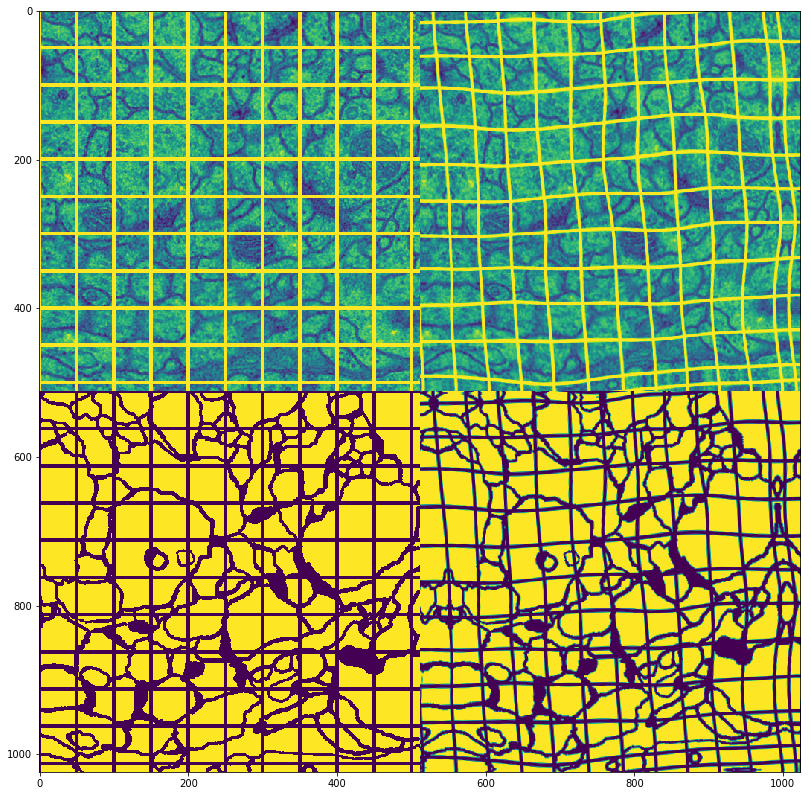

In [12]:
# First sample...

# Apply transformation on image
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] * 0.08, im_merge.shape[1] * 0.08)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# Display result
plt.figure(figsize = (16,14))
#plt.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]], cmap='gray')
plt.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]])

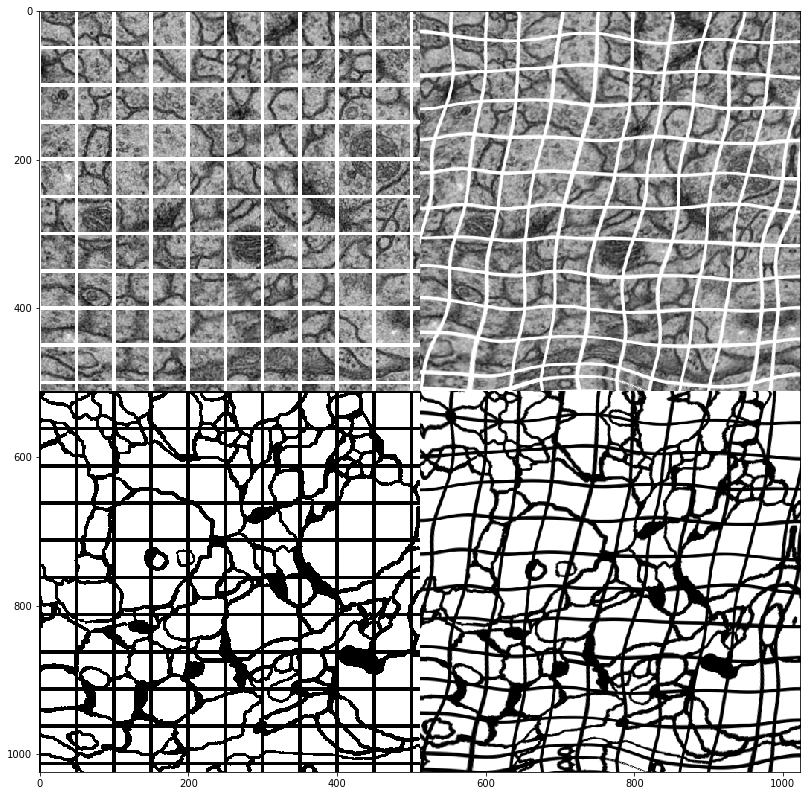

In [13]:
# Second sample (heavyer transform)...

# Apply transformation on image
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 3, im_merge.shape[1] * 0.07, im_merge.shape[1] * 0.09)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# Display result
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]], cmap='gray')